In [1]:
import os
import torch
import pickle
import argparse
import h5py
from torch.autograd import Variable
from model import NetD, NetG
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
from misc import get_logger, ges_Aonfig
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

In [2]:
from parse_metadata import EcommerceDataParser

In [3]:
def concat_image(images,nrows, ncols):
    width = 128
    height = 128
    
    background = Image.new('RGB',(128*ncols, 128*nrows), (255, 255, 255, 255))
    bg_w, bg_h = background.size
    
    for i,image in enumerate(images):
    #print(i)
        img = image
        draw = ImageDraw.Draw(img, "RGB")
        #font = ImageFont.truetype("/Library/Fonts/Arial.ttf",50)
        #draw.text((50, 50), str(i),)
        start_X = i%ncols * 128
        start_Y = i//ncols * 128
        offset = (start_X,start_Y,start_X+width,start_Y+height)
        background.paste(img,offset)
        
    return background

In [4]:
checkpoint_path = 'outputs/netg_checkpoints_0-995/netG__epoch_995.pth'

In [5]:
n_z = 100
n_l = 100
n_t = 300
n_c = 64
netG = NetG(n_z=n_z, n_l=n_l, n_c=n_c, n_t=n_t)
netG.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [6]:
transform = transforms.Compose([transforms.ToPILImage(),])

In [7]:
netG.zero_grad()

### train sample

In [10]:
config = ges_Aonfig('configs/config-real.yaml')['PARSEMETA']
config

{'META_PATH': 'data/datasets/products/metadata.json.gz',
 'TITLES_PATH': 'data/spm/titles.txt',
 'SPM_DIR_PATH': 'data/spm',
 'SPM_WP_PATH': 'data/spm/spm.vocab',
 'CATEGORY_PATH': 'data/datasets/products/category.txt',
 'PARSE_DATA_PATH': 'data/datasets/products/products.tsv',
 'DOC2VEC_DIR_PATH': 'data/doc2vec',
 'USE_COLS': ['asin', 'imUrl', 'title', 'categories'],
 'USE_CATE': [],
 'N_SHUFFLE': 4,
 'CATE_DEPTH': 4,
 'VOCAB_SIZE': 5000,
 'N_SAMPLE': 10000000,
 'N_LOG_PRINT': 10000,
 'DOC_VEC_SIZE': 300,
 'DOC2CEC_EPOCHS': 100,
 'N_WORKERS': 20,
 'WINDOW_SIZE': 4}

In [11]:
config['SPM_DIR_PATH'] = 'data/g_spm'
config['SPM_WP_PATH'] = 'data/g_spm/spm.vocab'
config['PARSE_DATA_PATH'] = 'data/datasets/products/g_products.tsv'
config['DOC2VEC_DIR_PATH'] = 'data/g_doc2vec'

In [12]:
parser = EcommerceDataParser(config, use=True)

[INFO    ] 2019-02-27 02:33:39 [parse_metadata.py] [load_spm:50] USE MODE LOAD SPM
[INFO    ] 2019-02-27 02:33:39 [parse_metadata.py] [load_spm:57] USE MODE LOAD SPM DONE: 0 sec
[INFO    ] 2019-02-27 02:33:39 [parse_metadata.py] [load_doc2vec_model:292] USE MODE LOAD DOC2VEC
[INFO    ] 2019-02-27 02:33:39 [parse_metadata.py] [get_doc_list:266] yamaha classical nylon string guitars yamaha c40 full size nylon string classical guitar ['▁yamaha', '▁classical', '▁nylon', '▁string', '▁guitars', '▁yamaha', '▁c', '40', '▁full', '▁size', '▁nylon', '▁string', '▁classical', '▁guitar'] [36, 15, 21, 7, 5, 36, 40, 305, 135, 45, 21, 7, 15, 2] 0 sec
[INFO    ] 2019-02-27 02:33:40 [parse_metadata.py] [get_doc_list:266] shine sra596 solid body ['▁shine', '▁sra', '59', '6', '▁solid', '▁body'] [783, 2453, 1577, 162, 6, 4] 0 sec
[INFO    ] 2019-02-27 02:33:40 [parse_metadata.py] [load_doc2vec_model:296] USE MODE LOAD DOC2VEC DONE: 1 sec


In [13]:
df = pd.read_csv('./data/datasets/products/g_products.tsv',sep='\t',header=None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15802 entries, 0 to 15801
Data columns (total 4 columns):
0    15802 non-null object
1    15802 non-null object
2    15802 non-null object
3    15802 non-null object
dtypes: object(4)
memory usage: 493.9+ KB


In [14]:
df[[1,2]].head()

,1,2
0,MusicalInstruments>Guitars>Classical&Nylon-StringGuitars,yamaha classical nylon string guitars yamaha c40 full size nylon string classical guitar
1,MusicalInstruments>Guitars>Classical&Nylon-StringGuitars,yamaha yamaha c40 full size nylon string classical guitar classical nylon string guitars
2,MusicalInstruments>Guitars>Classical&Nylon-StringGuitars,classical nylon string guitars yamaha yamaha c40 full size nylon string classical guitar
3,MusicalInstruments>Guitars>Classical&Nylon-StringGuitars,classical nylon string guitars yamaha c40 full size nylon string classical guitar yamaha
4,MusicalInstruments>Guitars>AcousticGuitars,first act acoustic guitar mg311 acoustic guitars


In [114]:
n= 0

images = []
real_images = []
imgdir = 'data/datasets/products/images'
temp_df = []
for index in range(n,n+10):
    asin = df[0][index] + '.jpg'
    title = df[2][index]
    real_images.append(Image.open(os.path.join(imgdir,asin)).resize((128,128)))
    vec = parser.text2vec(title)
    caption = Variable(torch.from_numpy(vec.reshape(1,-1)))
    noise = Variable(torch.randn(1, 100)) # create random noise
    noise.data.normal_(0,1) # normalize the noise
    fake = netG(noise, caption)
    img = transform(fake[0].data)
    images.append(img)
    temp_df.append(df.loc[[index]])
pd.concat(temp_df)[[1,2]]

,1,2
0,MusicalInstruments>Guitars>Classical&Nylon-StringGuitars,yamaha classical nylon string guitars yamaha c40 full size nylon string classical guitar
1,MusicalInstruments>Guitars>Classical&Nylon-StringGuitars,yamaha yamaha c40 full size nylon string classical guitar classical nylon string guitars
2,MusicalInstruments>Guitars>Classical&Nylon-StringGuitars,classical nylon string guitars yamaha yamaha c40 full size nylon string classical guitar
3,MusicalInstruments>Guitars>Classical&Nylon-StringGuitars,classical nylon string guitars yamaha c40 full size nylon string classical guitar yamaha
4,MusicalInstruments>Guitars>AcousticGuitars,first act acoustic guitar mg311 acoustic guitars
5,MusicalInstruments>Guitars>AcousticGuitars,acoustic guitars first act acoustic guitar mg311
6,MusicalInstruments>Guitars>Classical&Nylon-StringGuitars,classical nylon string guitars yamaha c40c full size classical acoustic guitar
7,MusicalInstruments>Guitars>Classical&Nylon-StringGuitars,yamaha c40c full size classical acoustic guitar classical nylon string guitars
8,MusicalInstruments>Guitars>AcousticGuitars>Steel-stringAcoustics,martin d45 acoustic guitar steel string acoustics
9,MusicalInstruments>Guitars>AcousticGuitars>Steel-stringAcoustics,steel string acoustics martin d45 acoustic guitar


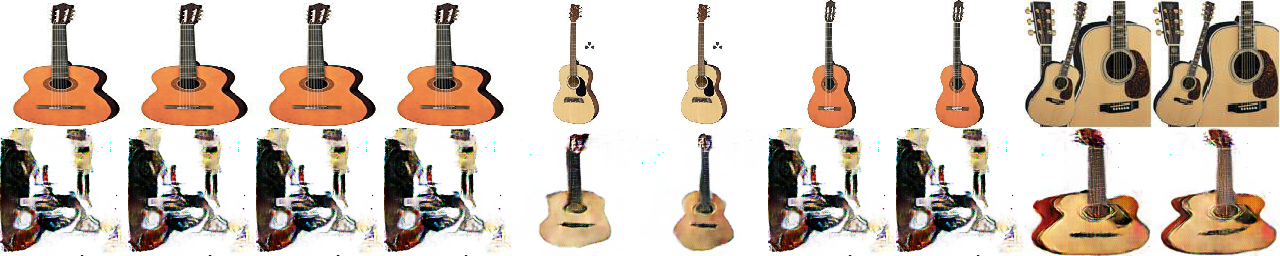

In [115]:
concat_image(real_images + images,2,len(images)) # 1950

### val sample

### test sample

In [17]:
check_text = [
    'guitars', 'taylor bar 8 baritone guitar 8 string indian rosewood acoustic guitars', 'blueridge br 140 historic dreadnaught guitar steel string acoustics blue ridge', 'first act acoustic guitars',
    'guitars', 'solid body schecter model t electric bass butterscotch', 'dean solid body electric guitars', 'solid body shred x explorer electric guitar ebony standard',
    'guitars', 'cherry solid body electric guitars', 'sea blue solid body schecter electric guitar', 'solid body schecter electric guitar black']



In [18]:
imgs = []
for i, t in enumerate(check_text):
    text = t #'schecter c 1 classic electric guitar blue solid body'
    caption = Variable(torch.from_numpy(parser.text2vec(text).reshape(1,-1)))
    noise = Variable(torch.randn(1, 100)) # create random noise
    noise.data.normal_(0,1) # normalize the noise
    fake = netG(noise, caption)
    img = transform(fake[0].data)
    imgs.append(img)

In [23]:
blank = Image.new('RGB',(128, 128), (255, 255, 255, 255))

In [24]:
blackline = [blank]*4

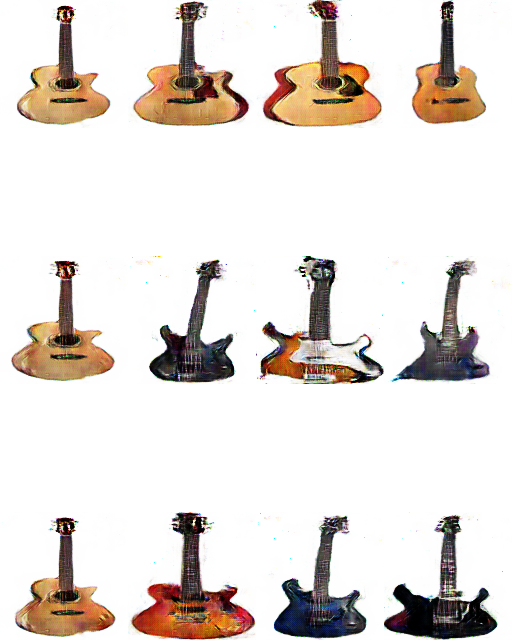

In [26]:
concat_image(imgs[:4] + blackline + imgs[4:8] + blackline + imgs[8:12],5,4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15895 entries, 0 to 15894
Data columns (total 4 columns):
0    15895 non-null object
1    15895 non-null object
2    15895 non-null object
3    15895 non-null object
dtypes: object(4)
memory usage: 496.8+ KB


In [507]:
df[[2]].head()

,2
0,yamaha c40 full size nylon string classical gu...
1,yamaha yamaha c40 full size nylon string class...
2,yamaha classical nylon string guitars guitars ...
3,classical nylon string guitars guitars yamaha ...
4,first act acoustic guitar mg311 acoustic guita...


In [47]:
s = df[1].value_counts()
s#s[(s>12000) & (s < 13500)]

MusicalInstruments>Guitars>ElectricGuitars>SolidBody                 6031
MusicalInstruments>Guitars>Acoustic-ElectricGuitars                  3302
MusicalInstruments>Guitars>AcousticGuitars>Steel-stringAcoustics     2199
MusicalInstruments>BassGuitars>ElectricBasses                        1561
MusicalInstruments>Guitars>Classical&Nylon-StringGuitars             1013
MusicalInstruments>Guitars>ElectricGuitars>Hollow&Semi-HollowBody     594
MusicalInstruments>Guitars>AcousticGuitars>Resonators                 428
MusicalInstruments>Guitars>AcousticGuitars                            257
MusicalInstruments>Guitars>ElectricGuitars                            240
MusicalInstruments>BassGuitars>Acoustic&Acoustic-ElectricBasses       177
Name: 1, dtype: int64

In [157]:
sub = df.drop_duplicates(subset=0).sample(5000)
imgdir = 'data/datasets/products/images/'
images = []
rows = []
sub.info()
for i, row in sub.iterrows():
    asin = row[0]
    title = row[2]
    print(i, asin, title)
    try:
        images.append(Image.open( imgdir+ asin +'.jpg').resize((128,128)))
        rows.append(row)
    except:
        pass
    if len(images) == 500:
        break


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 13096 to 346
Data columns (total 4 columns):
0    5000 non-null object
1    5000 non-null object
2    5000 non-null object
3    5000 non-null object
dtypes: object(4)
memory usage: 195.3+ KB
13096 B0082FEIOE fender 50th anniversary jaguar with gear guardian extended warranty candy apple red solid body
2284 B000P5R08K stiletto custom 5 string bass natural finish left handed lh schecter electric basses
12649 B007L58I2E solid body epiphone epiphone les paul custom pro electric guitar with probuckers and coil tapping ebony
7489 B003EUMTU2 solid body esp ltd viper 300fm electric guitar see thru black cherry
7120 B00389RUJE classical nylon string guitars acoustic guitar classical zebra wood stripe traditional nylon new
7707 B003GSC6LY acoustic electric guitars ovation dj ashba demented series dja34 chb acoustic electric guitar chrome bone
15294 B00F3T34WY classical nylon string guitars yamaha cgs103a 3 4 size classical guitar bu

5356 B001RIZ2OI schecter omen extreme 5 bass guitar black cherry electric basses schecter
4002 B001HN7HXM epiphone solid body epiphone les paul studio electric guitar alpine white
4390 B001MZW0SW steel string acoustics seagull coastline s6 burst gt guitar
11651 B0064RHHQS skb sg case w tsa latch solid body
11602 B0061NSUUW jackson solid body jackson slx soloist x series electric guitar burnt cherry sunburst
4110 B001J1RY3A steinberger synapse xs 1fpa custom bass guitar with gigbag trans amber electric basses
7294 B003C1LKD0 solid body fender american deluxe strat reg ash electric guitar wine transparent maple fretboard
8783 B0041T40IE solid body dbz diamond guitars imfm atb imperial fm electric guitar amber tobacco burst
11327 B005NJ3EK6 solid body gretsch g5434 pro jet electric guitar left handed 2 tone sunburst
6046 B002AMUBY6 acoustic electric guitars michael kelly nostalgia n40ce n40ce acoustic electric guitar
11425 B005PXFRPK washburn wd10sce dreadnought cutaway acoustic electric 

11560 B005XLFQRS the loar lh 309 vs archtop guitar with p 90 pickup the loar steel string acoustics
10991 B005D1F2ZE steel string acoustics washburn washburn wd100dl dreadnought mahogany acoustic guitar black
9715 B004NIG6H6 seagull acoustic electric guitars seagull entourage cw gt qi acoustic electric guitar burgundy
509 B0002F793E yamaha rbx375 5 string electric bass guitar black electric basses
6715 B002YPBW24 solid body danelectro original factory spec model 59 o electric guitar copper
8680 B00404YKT4 austin ast100bk double cutaway electric guitar sunburst solid body
1169 B0007DGON2 beginner 38 blue guitar with carrying bag and accessories steel string acoustics
1546 B000EEHJJ2 acoustic electric guitars applause by ovation ae148 4 acoustic electric guitar
13723 B009OJI3GQ solid body ibanez s421 electric guitar blackberry sunburst
2371 B000QDPR2W lakland electric basses lakland skyline series 55 01 5 strings bass guitar three tone sunburst
10460 B004Y4GVP6 regal rd 30v series studio

12023 B0072QOD9Y solid body jackson js32rt dinky electric guitar black
901 B0002H0HAY solid body gibson custom joe perry boneyard les paul electric guitar
7372 B003C80SEK seagull artist studio cw qii acoustic electric guitar acoustic electric guitars sea gull lighting
13457 B008QVR1Q6 schecter damien special electric guitar with floyd rose tremolo black solid body
13500 B008VU4MPU main street guitars main street ma241tsb 41 inch dreadnought size acoustic guitar with covered machine heads acoustic guitars
2601 B000VG4CM0 ovation celebrity cc24 acoustic electric guitar natural quilt acoustic electric guitars
11508 B005T4R0M8 yamaha apx500ii bl acoustic electric guitar w thinline hardshell case and guitar stand acoustic electric guitars
1336 B000B6AGGQ taylor guitars acoustic electric guitars taylor guitars 614ce grand auditorium acoustic electric guitar
11688 B0064RS780 acoustic electric guitars esp ltd xtone dc 6e natural satin acoustic electric guitar with gig bag cable tuner strap dvd

9131 B004ERFCP8 steel string acoustics guild d 40 standard acoustic guitar natural 886830424922
15218 B00EJ3HSD6 squier by fender vintage modified '51 2 tone sunburst solid body fender
11888 B006JW20CE acoustic acoustic electric basses sojing 4 string cutaway acoustic electric bass guitar
9903 B004Q7CVDM acoustic electric guitars boulder creek guitars erj6 n acoustic electric guitar natural finish
4807 B001QOGL9I recording king steel string acoustics recording king rd 06 classic series dreadnought
2572 B000UW10BQ solid body dean evo guitar special flame trans amberburst
1410 B000BRMXSE acoustic guitars rawlings rawker guitar
13233 B008CMVW64 washburn steel string acoustics washburn vintage series hb36k acoustic guitar vintage matte
8331 B003V4BRHM classical nylon string guitars valencia vg 180 classical guitar high gloss amber finish
13558 B00946E7CI michael kelly michael kelly patriot baritone burled trans red burst electric guitar solid body
9606 B004MM8ORS ibanez grga42tqa electric 

In [158]:
info_df = pd.concat(rows,axis=1).T.reset_index(drop=True)

In [159]:
info_df

,0,1,2,3
0,B0082FEIOE,MusicalInstruments>Guitars>ElectricGuitars>SolidBody,fender 50th anniversary jaguar with gear guardian extended warranty candy apple red solid body,http://ecx.images-amazon.com/images/I/41BIQGtgb5L._SY300_.jpg
1,B000P5R08K,MusicalInstruments>BassGuitars>ElectricBasses,stiletto custom 5 string bass natural finish left handed lh schecter electric basses,http://ecx.images-amazon.com/images/I/31keDmaWt-L._SY300_.jpg
2,B007L58I2E,MusicalInstruments>Guitars>ElectricGuitars>SolidBody,solid body epiphone epiphone les paul custom pro electric guitar with probuckers and coil tapping ebony,http://ecx.images-amazon.com/images/I/41WKdlcd0CL._SY300_.jpg
3,B003EUMTU2,MusicalInstruments>Guitars>ElectricGuitars>SolidBody,solid body esp ltd viper 300fm electric guitar see thru black cherry,http://ecx.images-amazon.com/images/I/41oCHy4IkgL._SX300_.jpg
4,B00389RUJE,MusicalInstruments>Guitars>Classical&Nylon-StringGuitars,classical nylon string guitars acoustic guitar classical zebra wood stripe traditional nylon new,http://ecx.images-amazon.com/images/I/41xksdu0TFL._SX300_.jpg
5,B003GSC6LY,MusicalInstruments>Guitars>Acoustic-ElectricGuitars,acoustic electric guitars ovation dj ashba demented series dja34 chb acoustic electric guitar chrome bone,http://ecx.images-amazon.com/images/I/41YDooNAdlL._SX300_.jpg
6,B00F3T34WY,MusicalInstruments>Guitars>Classical&Nylon-StringGuitars,classical nylon string guitars yamaha cgs103a 3 4 size classical guitar bundle with gig bag tuner instructional dvd strings pick card and polishing cloth,http://ecx.images-amazon.com/images/I/41Wnlh4ONSL._SY300_.jpg
7,B004WDQ4NI,MusicalInstruments>Guitars>Acoustic-ElectricGuitars,recording king acoustic electric guitars recording king rp2 626 cfe1 studio series size 00 acoustic electric guitar with cutaway,http://ecx.images-amazon.com/images/I/31qev40lrbL._SY300_.jpg
8,B003SPSH0O,MusicalInstruments>Guitars>AcousticGuitars,gibson blues king acoustic guitar vintage sunburst acoustic guitars,http://ecx.images-amazon.com/images/I/41yiMIOJGPL._SY300_.jpg
9,B003HKRYG8,MusicalInstruments>Guitars>AcousticGuitars>Steel-stringAcoustics,steel string acoustics taylor guitars gc5 e grand concert acoustic guitar,http://ecx.images-amazon.com/images/I/31%2BXgF-G1RL._SY300_.jpg


In [320]:
n= 331
images = []
real_images = []
imgdir = 'data/datasets/products/images'
temp_df = []
for index in range(n,n+10):
    asin = info_df[0][index] + '.jpg'
    title = info_df[2][index]
    real_images.append(Image.open(os.path.join(imgdir,asin)).resize((128,128)))
    vec = parser.text2vec(title)
    caption = Variable(torch.from_numpy(vec.reshape(1,-1)))
    noise = Variable(torch.randn(1, 100)) # create random noise
    noise.data.normal_(0,1) # normalize the noise
    fake = netG(noise, caption)
    img = transform(fake[0].data)
    images.append(img)
    temp_df.append(info_df.loc[[index]])
pd.concat(temp_df)[[1,2]]

,1,2
331,MusicalInstruments>Guitars>ElectricGuitars>SolidBody,solid body schecter sgr avenger electric guitar with schecter gig bag metallic black
332,MusicalInstruments>Guitars>ElectricGuitars>SolidBody,solid body jackson js32rt dinky electric guitar black
333,MusicalInstruments>Guitars>ElectricGuitars>SolidBody,solid body gibson custom joe perry boneyard les paul electric guitar
334,MusicalInstruments>Guitars>Acoustic-ElectricGuitars,seagull artist studio cw qii acoustic electric guitar acoustic electric guitars sea gull lighting
335,MusicalInstruments>Guitars>ElectricGuitars>SolidBody,schecter damien special electric guitar with floyd rose tremolo black solid body
336,MusicalInstruments>Guitars>AcousticGuitars,main street guitars main street ma241tsb 41 inch dreadnought size acoustic guitar with covered machine heads acoustic guitars
337,MusicalInstruments>Guitars>Acoustic-ElectricGuitars,ovation celebrity cc24 acoustic electric guitar natural quilt acoustic electric guitars
338,MusicalInstruments>Guitars>Acoustic-ElectricGuitars,yamaha apx500ii bl acoustic electric guitar w thinline hardshell case and guitar stand acoustic electric guitars
339,MusicalInstruments>Guitars>Acoustic-ElectricGuitars,taylor guitars acoustic electric guitars taylor guitars 614ce grand auditorium acoustic electric guitar
340,MusicalInstruments>Guitars>Acoustic-ElectricGuitars,acoustic electric guitars esp ltd xtone dc 6e natural satin acoustic electric guitar with gig bag cable tuner strap dvd strings and pick sampler


In [321]:
index = n
showimages = images
info_df[index:index+10]

,0,1,2,3
331,B009P15LKY,MusicalInstruments>Guitars>ElectricGuitars>SolidBody,solid body schecter sgr avenger electric guitar with schecter gig bag metallic black,http://ecx.images-amazon.com/images/I/312YDHXgcFL._SY300_.jpg
332,B0072QOD9Y,MusicalInstruments>Guitars>ElectricGuitars>SolidBody,solid body jackson js32rt dinky electric guitar black,http://ecx.images-amazon.com/images/I/41Hm6EnL%2B8L._SY300_.jpg
333,B0002H0HAY,MusicalInstruments>Guitars>ElectricGuitars>SolidBody,solid body gibson custom joe perry boneyard les paul electric guitar,http://ecx.images-amazon.com/images/I/41qfcQDKbLL._SX300_.jpg
334,B003C80SEK,MusicalInstruments>Guitars>Acoustic-ElectricGuitars,seagull artist studio cw qii acoustic electric guitar acoustic electric guitars sea gull lighting,http://ecx.images-amazon.com/images/I/31NjB3Lsr0L._SY300_.jpg
335,B008QVR1Q6,MusicalInstruments>Guitars>ElectricGuitars>SolidBody,schecter damien special electric guitar with floyd rose tremolo black solid body,http://ecx.images-amazon.com/images/I/31qPV8wmgbL._SY300_.jpg
336,B008VU4MPU,MusicalInstruments>Guitars>AcousticGuitars,main street guitars main street ma241tsb 41 inch dreadnought size acoustic guitar with covered machine heads acoustic guitars,http://ecx.images-amazon.com/images/I/315AZkHJBNL._SY300_.jpg
337,B000VG4CM0,MusicalInstruments>Guitars>Acoustic-ElectricGuitars,ovation celebrity cc24 acoustic electric guitar natural quilt acoustic electric guitars,http://ecx.images-amazon.com/images/I/41VlYahtXEL._SY300_.jpg
338,B005T4R0M8,MusicalInstruments>Guitars>Acoustic-ElectricGuitars,yamaha apx500ii bl acoustic electric guitar w thinline hardshell case and guitar stand acoustic electric guitars,http://ecx.images-amazon.com/images/I/41WBjRSPMJL._SY300_.jpg
339,B000B6AGGQ,MusicalInstruments>Guitars>Acoustic-ElectricGuitars,taylor guitars acoustic electric guitars taylor guitars 614ce grand auditorium acoustic electric guitar,http://ecx.images-amazon.com/images/I/31dDNj2C%2BiL._SY300_.jpg
340,B0064RS780,MusicalInstruments>Guitars>Acoustic-ElectricGuitars,acoustic electric guitars esp ltd xtone dc 6e natural satin acoustic electric guitar with gig bag cable tuner strap dvd strings and pick sampler,http://ecx.images-amazon.com/images/I/517ndTK92vL._SY300_.jpg


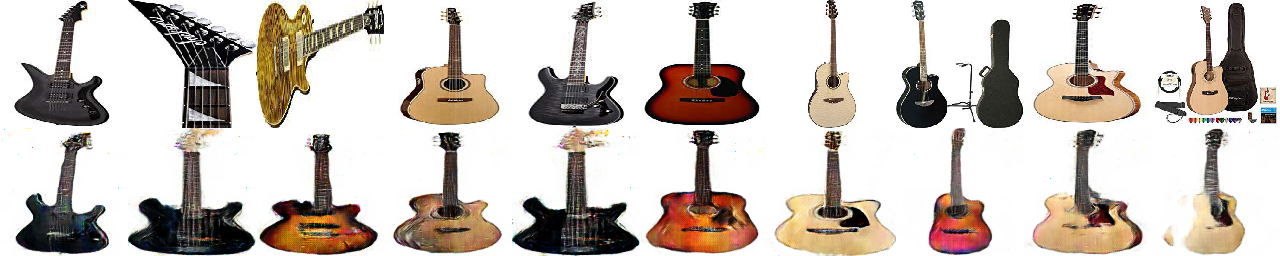

In [324]:
concat_image(real_images+showimages,2,len(showimages))#.save('guitar_gt.jpg')

In [409]:
check_text = ['natural acoustic guitars']*4
images = []
for i, t in enumerate(check_text):
    text = t #'schecter c 1 classic electric guitar blue solid body'
    caption = Variable(torch.from_numpy(parser.text2vec(text).reshape(1,-1)))
    noise = Variable(torch.randn(1, 100)) # create random noise
    noise.data.normal_(0,1) # normalize the noise
    fake = netG(noise, caption)
    img = transform(fake[0].data)
    images.append(img)

In [411]:
concat_image(images,2,2)#.save('noise_vari_guitar.jpg')

# cate select

In [ ]:
# ,Clothing,Shoes&Jewelry>adidas
# ,Home&Kitchen>Furniture>LivingRoomFurniture>Tables
# ,Clothing,Shoes&Jewelry>Women>Clothing>Coats&Jackets
# ,Beauty>Makeup>Lips>Lipstick
# ,Clothing,Shoes&Jewelry>Women>Shoes>Boots
# ,Clothing,Shoes&Jewelry>Girls>Clothing>Dresses
# ,Clothing,Shoes&Jewelry>Women>Accessories>Hats&Caps
# ,Clothing,Shoes&Jewelry>Women>Clothing>Skirts
# ,Clothing,Shoes&Jewelry>Women>Handbags&Wallets>ShoulderBags
# ,Automotive>Motorcycle&Powersports>ProtectiveGear>Helmets
# ,Clothing,Shoes&Jewelry>N>Nike
# ,Tools&HomeImprovement>Lighting&CeilingFans>Lamps&Shades>TableLamps